# Model Predictive Control Demo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mpc_tools as mpc

## Setup

In this demo Model Predictive Control (MPC) is applied to stibilize a linear inverted pendulum with mass $m$ and length $l$, subject to the gravity acceleration $g$.

In [2]:
m = 1.
l = 1.
g = 10.

The linearized continuous-time dynamics is 
\begin{equation}
\dot x = A x + B u =
\begin{bmatrix}
0 & 1 \\ g/l & 0
\end{bmatrix}
x +
\begin{bmatrix}
0 \\ 1/(ml^2)
\end{bmatrix}
u.
\end{equation}

In [3]:
A = np.array([[0., 1.], [g/l, 0.]])
B = np.array([[0.], [1/(m*l**2.)]])

At each sampling, time an optimal control problem with $N$ time steps and a sampling time $t_s$ is solved.

In [4]:
N = 5
t_s = .1

Constraints can be enforced on both the state
$
x_{max} \geq x_k \geq x_{min}
\ (k = 1,2,\ldots,N)
$
and the input
$
u_{max} \geq u_k \geq u_{min}
\ (k = 0,1,\ldots,N-1).
$




In [5]:
x_max = np.array([[np.pi/6.],[np.pi/22./(N*t_s)]])
x_min = -x_max
u_max = np.array([[m*g*l*np.pi/8.]])
u_min = -u_max

The cost function is the sum of a stage cost and a terminal cost
\begin{equation}
\sum_{k=0}^{N-1} (x_k^T Q x_k + u_k^T R u_k) + x_N^T P x_N.
\end{equation}
By default $P=Q$ but, for staibility reasons, it's in general preferable to use the solution of the Discrete Algebraic Ricccati Equation (DARE)
\begin{equation}
P = (A+BK)^T P (A+BK) + Q + K^T R K
\end{equation}
with the optimal feedback $u_k = K x_k$, where
\begin{equation}
K = -(B^T P B + R)^{-1} B^T P A.
\end{equation}
This can be done setting $\texttt{terminal_cost = 'dare'}$.


In [6]:
Q = np.eye(A.shape[0])/100.
R = np.eye(B.shape[1])
terminal_cost = 'dare'

To ensure stability of the closed loop system two terminal constraints are available:

1) $\texttt{terminal_constraint = 'origin'}$: this option imposes $x_N = 0$ which is sufficient to ensure stability (regardless the terminal cost) but in most cases it's excessive.

2) $\texttt{terminal_constraint = 'moas'}$: this option imposes $x_N \in \mathcal{X}_{\infty}$ where $\mathcal{X}_{\infty}$ denotes the Maximum Output Admissible Set for the system closed loop system $x_{k+1} = (A + BK) x_k$, with $K$ derived from the DARE.
Mathematically speaking, we have that $x_N \in \mathcal{X}_{\infty} \Leftrightarrow \{ x_{max} \geq x_k \geq x_{min} \wedge u_{max} \geq K x_k \geq u_{min} \} \ \forall k \geq N$.
This constraint, if coupoled with the DARE terminal cost, is sufficient condition for the stability of the closed loop system.

In [7]:
terminal_constraint = 'moas'

## Simulation

Here we simulate the closed loop system for $N_{sim}$ steps starting from the initial condition $x_0$.

In [8]:
N_sim = 50
x_0 = np.array([[np.pi/10.],[0.]])

The discrete-time linear system can be defined from its continuous-time representation (the exact zero-order-hold discretization is used) and bounds are added to the system evolution.

In [9]:
sys = mpc.DTLinearSystem.from_continuous(t_s, A, B)
sys.add_state_bounds(x_max, x_min)
sys.add_input_bounds(u_max, u_min)

We define the MPC controller.

In [10]:
controller = mpc.MPCController(sys, Q, R, N, terminal_cost, terminal_constraint)

We simulate the closed-loop system.

In [11]:
u = []
x = []
x.append(x_0)
for k in range(0, N_sim):
    u.append(controller.feedback(x[k]))
    x.append(sys.A.dot(x[k]) + sys.B.dot(u[k]))

Plot the solution using the functions $\texttt{plot_input_sequence(.)}$ and $\texttt{plot_state_trajectory(.)}$

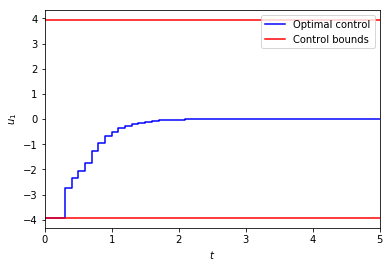

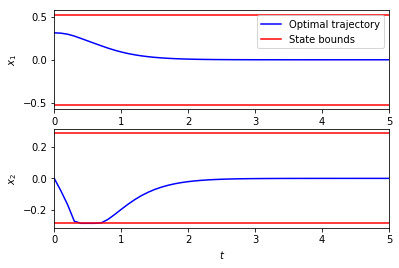

In [12]:
mpc.plot_input_sequence(u, t_s, N_sim, u_max, u_min)
plt.show()
mpc.plot_state_trajectory(x, t_s, N_sim, x_max, x_min)
plt.show()

Get the explict solution of the optimal control problem and plot the state partition.

Computing critical region for the active set []
Computing critical region for the active set [0]
Computing critical region for the active set [1]
Computing critical region for the active set [10]
Computing critical region for the active set [11]
Computing critical region for the active set [12]
Computing critical region for the active set [13]
Computing critical region for the active set [14]
Computing critical region for the active set [15]
Computing critical region for the active set [0, 2]
LICQ does not hold for the active set [0, 11]
    unfeasible region detected
Computing critical region for the active set [0, 14]
Computing critical region for the active set [0, 16]
Computing critical region for the active set [1, 3]
LICQ does not hold for the active set [1, 10]
    unfeasible region detected
Computing critical region for the active set [1, 15]
Computing critical region for the active set [1, 17]
Computing critical region for the active set [10, 12]
Computing critical region for 

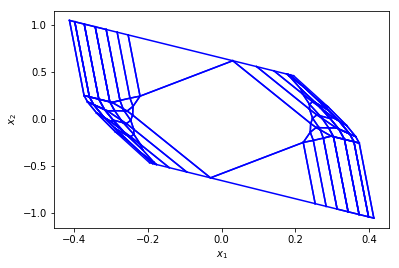

In [13]:
controller.compute_explicit_solution()
for cr in controller.critical_regions:
    cr.polyhedron.plot()
plt.show()

Compare the explicit and the implicit solutions for the initial state $x_0$

In [14]:
u_explicit = controller.evaluate_explicit_solution(x_0)[0]
u_implicit = controller.feedforward(x_0)
print('Optimal control from the explicit solution: ' + str(u_explicit.flatten()))
print('Optimal control from the implicit solution: ' + str(u_implicit.flatten()))

Optimal control from the explicit solution: [-3.92699082 -3.92699082 -3.92699082 -2.75365566 -1.88596365]
Optimal control from the implicit solution: [-3.92699082 -3.92699082 -3.92699082 -2.75365566 -1.88596365]
